<a href="https://colab.research.google.com/github/EduHdzVillasana/COVIDSTATSMX/blob/master/An%C3%A1lisis%20y%20Modelado/Modelo_Predictorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creación de modelo para predecir probabilidad de muerte por COVID-19
En este notebook se creará un modelo de regresión logística para predecir la probabilidad de muerte de un paciente positivo a sars-cov-2 dadas sus condiciones.

También se creará un modelo para predecir la probabilidad de contraer enfermedad grave dadas sus condiciones y así identificar personas vulnerables.

## Librerías a utilizar


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

# Librerias para la regresión logística
import statsmodels.api as sm
from sklearn import datasets
from sklearn.feature_selection import RFE
from tabulate import tabulate
from sklearn import linear_model
from sklearn import preprocessing

# Librerias para la validación del modelo
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
mainpath = "/content/drive/MyDrive/Datos Abiertos"
filepath = "210401COVID19MEXICO_filtered.csv"

data = pd.read_csv(os.path.join(mainpath, filepath), index_col=0)
data.sample(3)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,RESULTADO,TIEMPO_ESPERA,FALLECIDO,ENFERMEDAD_GRAVE,HOSPITALIZADO,SEXO_,SECTOR_ATENDIDO,ESTADO
496584,2021-04-01,7bf2f2,2,12,9,1,9,9,12,1,2021-02-02,2021-01-31,9999-99-99,0,0,29,1,0,2,2,0,0,0,0,0,0,0,0,0,0,2,2,97,1,1,3,99,México,97,0,1,2,0,0,0,MUJER,SSA,DF
1706673,2021-04-01,dc07ae,2,4,21,2,21,21,114,1,2021-03-22,2021-03-16,9999-99-99,0,0,50,1,0,2,2,1,0,0,0,0,0,0,1,0,0,2,2,97,1,1,3,99,México,97,0,1,6,0,0,0,HOMBRE,IMSS,PL
1054040,2021-04-01,27d236,1,12,19,2,19,19,26,1,2020-10-20,2020-10-19,9999-99-99,0,0,16,1,0,2,2,0,0,0,0,0,0,0,0,0,0,2,1,1,2,97,3,99,México,97,0,1,1,0,0,0,HOMBRE,SSA,NL


In [3]:
columns = ['EDAD', 'EMBARAZO','DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'TIEMPO_ESPERA', 'HOSPITALIZADO','SEXO_','SECTOR_ATENDIDO','ESTADO','ENFERMEDAD_GRAVE','FALLECIDO']
data = data[columns]

## Preparación de datos

In [4]:
data = data.rename({"SEXO_":"SEXO"}, axis = 1)

In [5]:
data.columns

Index(['EDAD', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR',
       'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'TIEMPO_ESPERA', 'HOSPITALIZADO', 'SEXO',
       'SECTOR_ATENDIDO', 'ESTADO', 'ENFERMEDAD_GRAVE', 'FALLECIDO'],
      dtype='object')

### Creación de variables dummies (catagóricas)

In [6]:
categories = ["SEXO","SECTOR_ATENDIDO","ESTADO"]
for cat in categories:
  cat_dummies = pd.get_dummies(data[cat], prefix = cat)
  data = data.join(cat_dummies)

In [7]:
data.columns

Index(['EDAD', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR',
       'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'TIEMPO_ESPERA', 'HOSPITALIZADO', 'SEXO',
       'SECTOR_ATENDIDO', 'ESTADO', 'ENFERMEDAD_GRAVE', 'FALLECIDO',
       'SEXO_HOMBRE', 'SEXO_MUJER', 'SECTOR_ATENDIDO_CRUZ ROJA',
       'SECTOR_ATENDIDO_DIF', 'SECTOR_ATENDIDO_ESTATAL',
       'SECTOR_ATENDIDO_IMSS', 'SECTOR_ATENDIDO_IMSS-BIENESTAR',
       'SECTOR_ATENDIDO_ISSSTE', 'SECTOR_ATENDIDO_MUNICIPAL',
       'SECTOR_ATENDIDO_PEMEX', 'SECTOR_ATENDIDO_PRIVADA',
       'SECTOR_ATENDIDO_SEDENA', 'SECTOR_ATENDIDO_SEMAR',
       'SECTOR_ATENDIDO_SSA', 'SECTOR_ATENDIDO_UNIVERSITARIO', 'ESTADO_AS',
       'ESTADO_BC', 'ESTADO_BS', 'ESTADO_CC', 'ESTADO_CH', 'ESTADO_CL',
       'ESTADO_CM', 'ESTADO_CS', 'ESTADO_DF', 'ESTADO_DG', 'ESTADO_GR',
       'ESTADO_GT', 'ESTADO_HG', 'ESTADO_JC', 'ESTADO_MC', 'ESTADO_MN',
       'ESTADO_MS', 'ESTADO_NL', 'ESTADO_NT', 'ESTADO_OC', 'E

In [8]:
# Columnas de las condiciones del paciente ántes de ser atendido por una institución de salud
before_columns = ['EDAD', 'EMBARAZO','DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'ESTADO_AS','SEXO_HOMBRE', 'SEXO_MUJER',
       'ESTADO_BC', 'ESTADO_BS', 'ESTADO_CC', 'ESTADO_CH', 'ESTADO_CL',
       'ESTADO_CM', 'ESTADO_CS', 'ESTADO_DF', 'ESTADO_DG', 'ESTADO_GR',
       'ESTADO_GT', 'ESTADO_HG', 'ESTADO_JC', 'ESTADO_MC', 'ESTADO_MN',
       'ESTADO_MS', 'ESTADO_NL', 'ESTADO_NT', 'ESTADO_OC', 'ESTADO_PL',
       'ESTADO_QR', 'ESTADO_QT', 'ESTADO_SL', 'ESTADO_SP', 'ESTADO_SR',
       'ESTADO_TC', 'ESTADO_TL', 'ESTADO_TS', 'ESTADO_VZ', 'ESTADO_YN',
       'ESTADO_ZS']

# Columnas de las condiciones del paciente después de ser atendido por una institución de salud
after_columns = ['EDAD', 'EMBARAZO','DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'TIEMPO_ESPERA', 'HOSPITALIZADO','SEXO_HOMBRE', 'SEXO_MUJER', 'SECTOR_ATENDIDO_CRUZ ROJA',
       'SECTOR_ATENDIDO_DIF', 'SECTOR_ATENDIDO_ESTATAL', 'SECTOR_ATENDIDO_IMSS', 'SECTOR_ATENDIDO_IMSS-BIENESTAR',
       'SECTOR_ATENDIDO_ISSSTE', 'SECTOR_ATENDIDO_MUNICIPAL', 'SECTOR_ATENDIDO_PEMEX', 'SECTOR_ATENDIDO_PRIVADA',
       'SECTOR_ATENDIDO_SEDENA', 'SECTOR_ATENDIDO_SEMAR', 'SECTOR_ATENDIDO_SSA', 'SECTOR_ATENDIDO_UNIVERSITARIO', 'ESTADO_AS',
       'ESTADO_BC', 'ESTADO_BS', 'ESTADO_CC', 'ESTADO_CH', 'ESTADO_CL',
       'ESTADO_CM', 'ESTADO_CS', 'ESTADO_DF', 'ESTADO_DG', 'ESTADO_GR',
       'ESTADO_GT', 'ESTADO_HG', 'ESTADO_JC', 'ESTADO_MC', 'ESTADO_MN',
       'ESTADO_MS', 'ESTADO_NL', 'ESTADO_NT', 'ESTADO_OC', 'ESTADO_PL',
       'ESTADO_QR', 'ESTADO_QT', 'ESTADO_SL', 'ESTADO_SP', 'ESTADO_SR',
       'ESTADO_TC', 'ESTADO_TL', 'ESTADO_TS', 'ESTADO_VZ', 'ESTADO_YN',
       'ESTADO_ZS']



### Eliminación de outlier
Se identificó que una columna posiblemente tenga datos atípicos. La columna `TIEMPO_ESPERA`

In [9]:
def summary(data):
  minimo = data.min()
  Q1 = data.quantile(0.25)
  median = data.median()
  mean = data.mean()
  Q2 = data.quantile(0.5)
  Q3 = data.quantile(0.75)
  maximo = data.max()
  IQR = Q3 - Q1
  resumen = {'minimo': minimo, 'Q1': Q1, 'mediana':median,'Q2':Q2,'Q3':Q3,'max':maximo,'IQR':IQR, 'media':mean}
  return resumen

In [10]:
print ("Resumen TIEMPO_ESPERA")
time_summary = summary(data["TIEMPO_ESPERA"])
time_summary

Resumen TIEMPO_ESPERA


{'IQR': 4.0,
 'Q1': 2.0,
 'Q2': 3.0,
 'Q3': 6.0,
 'max': 174,
 'media': 4.076062198742845,
 'mediana': 3.0,
 'minimo': 0}

{'boxes': [<matplotlib.lines.Line2D at 0x7ff8a1fd3650>],
 'caps': [<matplotlib.lines.Line2D at 0x7ff8a20c6490>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff8a1fd3ed0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ff89c492710>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7ff8a20c6b90>,
  <matplotlib.lines.Line2D at 0x7ff8a20c6950>]}

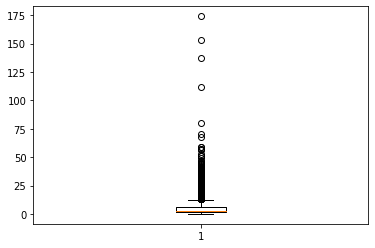

In [11]:
plt.boxplot(data["TIEMPO_ESPERA"])

In [12]:
data = data[data["TIEMPO_ESPERA"] <= time_summary["Q3"] + 1.5*time_summary["IQR"]]

### Normalización de datos numéroicos
Se normalizarán las variables de `EDAD` y `TIEMPO_ESPERA`

In [14]:
data["EDAD"].describe()

count    2.163626e+06
mean     4.355414e+01
std      1.700503e+01
min      0.000000e+00
25%      3.000000e+01
50%      4.200000e+01
75%      5.500000e+01
max      1.210000e+02
Name: EDAD, dtype: float64

In [15]:
scaled = preprocessing.MinMaxScaler()
scaled_edad = scaled.fit_transform(data["EDAD"].values.reshape(-1,1))
data["EDAD"] = scaled_edad

In [16]:
data["EDAD"].describe()

count    2.163626e+06
mean     3.599515e-01
std      1.405374e-01
min      0.000000e+00
25%      2.479339e-01
50%      3.471074e-01
75%      4.545455e-01
max      1.000000e+00
Name: EDAD, dtype: float64

In [17]:
data["TIEMPO_ESPERA"].describe()

count    2.163626e+06
mean     3.780447e+00
std      2.834329e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      6.000000e+00
max      1.200000e+01
Name: TIEMPO_ESPERA, dtype: float64

In [18]:
scaled = preprocessing.MinMaxScaler()
scaled_time = scaled.fit_transform(data["TIEMPO_ESPERA"].values.reshape(-1,1))
data["TIEMPO_ESPERA"] = scaled_time

In [19]:
data["TIEMPO_ESPERA"].describe()

count    2.163626e+06
mean     3.150373e-01
std      2.361941e-01
min      0.000000e+00
25%      1.666667e-01
50%      2.500000e-01
75%      5.000000e-01
max      1.000000e+00
Name: TIEMPO_ESPERA, dtype: float64

## Modelo para condiciones iniciales del paciente


### Selección de las varianbles

In [20]:
X_before = data[before_columns].copy()
Y_deceased = data["FALLECIDO"].copy()
len(before_columns)

46

In [21]:
data.columns

Index(['EDAD', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR',
       'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'TIEMPO_ESPERA', 'HOSPITALIZADO', 'SEXO',
       'SECTOR_ATENDIDO', 'ESTADO', 'ENFERMEDAD_GRAVE', 'FALLECIDO',
       'SEXO_HOMBRE', 'SEXO_MUJER', 'SECTOR_ATENDIDO_CRUZ ROJA',
       'SECTOR_ATENDIDO_DIF', 'SECTOR_ATENDIDO_ESTATAL',
       'SECTOR_ATENDIDO_IMSS', 'SECTOR_ATENDIDO_IMSS-BIENESTAR',
       'SECTOR_ATENDIDO_ISSSTE', 'SECTOR_ATENDIDO_MUNICIPAL',
       'SECTOR_ATENDIDO_PEMEX', 'SECTOR_ATENDIDO_PRIVADA',
       'SECTOR_ATENDIDO_SEDENA', 'SECTOR_ATENDIDO_SEMAR',
       'SECTOR_ATENDIDO_SSA', 'SECTOR_ATENDIDO_UNIVERSITARIO', 'ESTADO_AS',
       'ESTADO_BC', 'ESTADO_BS', 'ESTADO_CC', 'ESTADO_CH', 'ESTADO_CL',
       'ESTADO_CM', 'ESTADO_CS', 'ESTADO_DF', 'ESTADO_DG', 'ESTADO_GR',
       'ESTADO_GT', 'ESTADO_HG', 'ESTADO_JC', 'ESTADO_MC', 'ESTADO_MN',
       'ESTADO_MS', 'ESTADO_NL', 'ESTADO_NT', 'ESTADO_OC', 'E

Nos quedaremos con la mitad de las variables 

Se utiliza el solver sag porque es más rápido para datasets grandes (en variables y tamaño de la muestra)

* [Referencia 1](https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-defintions)
* [Referencia 2](https://rubialesalberto.medium.com/regresi%C3%B3n-log%C3%ADstica-con-sklearn-4384c707075d)

In [22]:
n = 23
lr = linear_model.LogisticRegression(solver="sag")
rfe = RFE(lr,n)
rfe = rfe.fit(X_before,Y_deceased)

In [23]:
var_included = list(zip(before_columns, rfe.support_, rfe.ranking_))
var_included.sort(key = lambda x: x[2])
print (tabulate(var_included))

--------------  -  --
EDAD            1   1
DIABETES        1   1
INMUSUPR        1   1
HIPERTENSION    1   1
OTRA_COM        1   1
OBESIDAD        1   1
RENAL_CRONICA   1   1
SEXO_HOMBRE     1   1
SEXO_MUJER      1   1
ESTADO_BC       1   1
ESTADO_BS       1   1
ESTADO_CH       1   1
ESTADO_CS       1   1
ESTADO_DF       1   1
ESTADO_HG       1   1
ESTADO_MC       1   1
ESTADO_NT       1   1
ESTADO_PL       1   1
ESTADO_QR       1   1
ESTADO_SL       1   1
ESTADO_TC       1   1
ESTADO_TL       1   1
ESTADO_VZ       1   1
ESTADO_OC       0   2
ESTADO_QT       0   3
ESTADO_NL       0   4
ESTADO_DG       0   5
ESTADO_SP       0   6
ESTADO_GT       0   7
ESTADO_SR       0   8
ESTADO_MS       0   9
EPOC            0  10
ESTADO_CC       0  11
ASMA            0  12
ESTADO_TS       0  13
ESTADO_ZS       0  14
ESTADO_AS       0  15
ESTADO_GR       0  16
TABAQUISMO      0  17
ESTADO_JC       0  18
EMBARAZO        0  19
ESTADO_CL       0  20
ESTADO_MN       0  21
ESTADO_CM       0  22
ESTADO_YN 